# GENG5551 Prototype Model Training 

Run code below if using google collab for training. If not skip to next section.

run container with:
sudo docker run --gpus all -it --rm -v $(pwd):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:2.12.0-gpu-jupyter

In [1]:
startup = True

In [2]:
# GB: Useless

# !pip install pandas
# !pip install scikit-learn
# !pip install seaborn
# !pip install akida==2.7.2
# !pip install cnn2snn==2.7.2
# %pip install akida-models==1.5.0

In [3]:
# GB: Same here
# !unzip notebooks/archive

## Dataset Preprocessing

Start here if running on anaconda virtual environment

- This section involves examining and pre-processing the data to make it suitable for use with the Akida models

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os, shutil, random

os.chdir('notebooks/Documents/GitHub/GENG5551-Akida-Chip')

In [5]:
os.getcwd()


'/tf/notebooks/Documents/GitHub/GENG5551-Akida-Chip'

In [6]:
# Define paths for train and test datasets
train_dir = 'archive/data/train'
test_dir = 'archive/data/test'

# Define the target directories for cancerous and benign images
train_normal_dir = 'archive/data/train/NORMAL'
train_pneumonia_dir = 'archive/data/train/PNEUMONIA'
test_normal_dir = 'archive/data/test/NORMAL'
test_pneumonia_dir = 'archive/data/test/PNEUMONIA'

In [7]:
# scale images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#     rescale=1.0/255.0,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode='binary',
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode='binary'
)

2024-09-30 02:52:00.541784: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 02:52:00.570135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5216 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


## Model Training

In [8]:
# GB: Change Akida version
import os
import cnn2snn
import akida as ak

# Change Akida version
os.environ["CNN2SNN_TARGET_AKIDA_VERSION"] = "v1"

# Double-check Avida version
print(' Akida version: ', cnn2snn.get_akida_version())

2024-09-30 02:52:01.455447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-30 02:52:01.459205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-30 02:52:01.459326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 Akida version:  AkidaVersion.v1


In [9]:
from akida_models import fetch_file, akidanet_imagenet, mobilenet_imagenet

# GB: Things have to be changed here. It shouldn't work with weights coming from v2 but it does.
# I thought there were a ready to use model: akidanet_imagenet_pretrained()
# In fact, yes, there is: https://doc.brainchipinc.com/api_reference/akida_models_apis.html#akida_models.akidanet_imagenet_pretrained
# With 0.5 and False, it should give the expected model.
# TO BE CHECKED
#base_model = akidanet_imagenet_trained(alpha=0.5, quantized=False)

IMG_SIZE = 224
# CLASSES = metadata['dx'].unique()
CLASSES = 2


# Create a base model without top layers
base_model = akidanet_imagenet(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                               classes=CLASSES,
                               alpha=0.5,
                               include_top=False,
                               pooling='avg')

# base_model = mobilenet_imagenet(input_shape=(IMG_SIZE, IMG_SIZE, 3),
#                                 classes=CLASSES,
#                                 alpha=1.0,
#                                 dropout=0.001,
#                                 include_top=False,
#                                 pooling='avg')

# Get pretrained quantized weights and load them into the base model
pretrained_weights = fetch_file(
    
    # GB: 
    #origin="https://data.brainchip.com/models/AkidaV2/akidanet/akidanet_imagenet_224_alpha_0.5.h5",
    # Commented line above and added line below
    origin='https://data.brainchip.com/models/AkidaV1/akidanet/akidanet_imagenet_224_alpha_50.h5',
    # origin='https://data.brainchip.com/models/AkidaV1/mobilenet/mobilenet_imagenet_224.h5',
    
    # GB: Other filename
    #fname="akidanet_imagenet_224_alpha_0.5.h5",
    fname="akidanet_imagenet_224_alpha_50.h5"
    # fname="mobilenet_imagenet_224.h5"
    
    # GB: no cache
    # cache_subdir='models'
    )

base_model.load_weights(pretrained_weights, by_name=True)
base_model.summary()

Model: "akidanet_0.50_224_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 112, 112, 16)      432       
                                                                 
 conv_0/BN (BatchNormalizati  (None, 112, 112, 16)     64        
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 112, 112, 16)      0         
                                                                 
 conv_1 (Conv2D)             (None, 112, 112, 32)      4608      
                                               

In [10]:
from keras import Model
from keras.layers import Activation, Dropout, Reshape
from akida_models.layer_blocks import dense_block

# GB: Only ReLU 6 are compatible
# And no softmax as activation on last layer. It will be removed anyway.
# Didn't change it either.

x = base_model.output
x = dense_block(x,
                units=512,
                name='fc1',
                add_batchnorm=True,
                # GB: Changed to ReLU 6
                #relu_activation='ReLU7.5')
                relu_activation='ReLU6')
x = Dropout(0.5, name='dropout_1')(x)
x = dense_block(x,
                units=CLASSES,
                name='predictions',
                add_batchnorm=False,
                relu_activation=False)

# GB: Softmax is impossible here
#x = Activation('softmax', name='act_softmax')(x)

x = Reshape((CLASSES,), name='reshape1')(x)

# Build the model
model_keras = Model(base_model.input, x, name='akidanet_derma')

model_keras.summary()

Model: "akidanet_derma"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 112, 112, 16)      432       
                                                                 
 conv_0/BN (BatchNormalizati  (None, 112, 112, 16)     64        
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 112, 112, 16)      0         
                                                                 
 conv_1 (Conv2D)             (None, 112, 112, 32)      4608      
                                                    

In [11]:
# GB: Adding compatibility check
import cnn2snn
import akida as ak

# Double-check Akida version
print('Akida version: ', cnn2snn.get_akida_version())

# And HW compatibility?
# myDevice = ak.devices()[1]
# print("Device: ", myDevice.desc)
# x = cnn2snn.check_model_compatibility(model=model_keras, device=myDevice)
# print("Non compatibilities: ", x)

Akida version:  AkidaVersion.v1


Epoch 1/15


2024-09-30 02:52:03.021066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-30 02:52:05.173108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-09-30 02:52:05.614173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-30 02:52:05.631778: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7260af2f5b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-30 02:52:05.631797: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-09-30 02:52:05

53/53 [==============================] - ETA: 0s - loss: 2.5322 - accuracy: 0.5763

2024-09-30 02:52:39.727544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


53/53 [==============================] - 39s 615ms/step - loss: 2.5322 - accuracy: 0.5763 - val_loss: 7.7451 - val_accuracy: 0.4062
Epoch 2/15
53/53 [==============================] - 32s 601ms/step - loss: 1.6077 - accuracy: 0.6054 - val_loss: 3.4145 - val_accuracy: 0.4453
Epoch 3/15
53/53 [==============================] - 32s 604ms/step - loss: 1.5094 - accuracy: 0.6020 - val_loss: 2.3187 - val_accuracy: 0.4984
Epoch 4/15
53/53 [==============================] - 32s 601ms/step - loss: 1.5438 - accuracy: 0.6150 - val_loss: 2.1876 - val_accuracy: 0.5156
Epoch 5/15
53/53 [==============================] - 32s 601ms/step - loss: 1.5483 - accuracy: 0.6112 - val_loss: 2.1594 - val_accuracy: 0.5422
Epoch 6/15
53/53 [==============================] - 32s 598ms/step - loss: 1.5134 - accuracy: 0.6041 - val_loss: 2.2803 - val_accuracy: 0.5625
Epoch 7/15
53/53 [==============================] - 32s 595ms/step - loss: 1.5946 - accuracy: 0.6064 - val_loss: 2.4034 - val_accuracy: 0.5531
Epoch 8/15

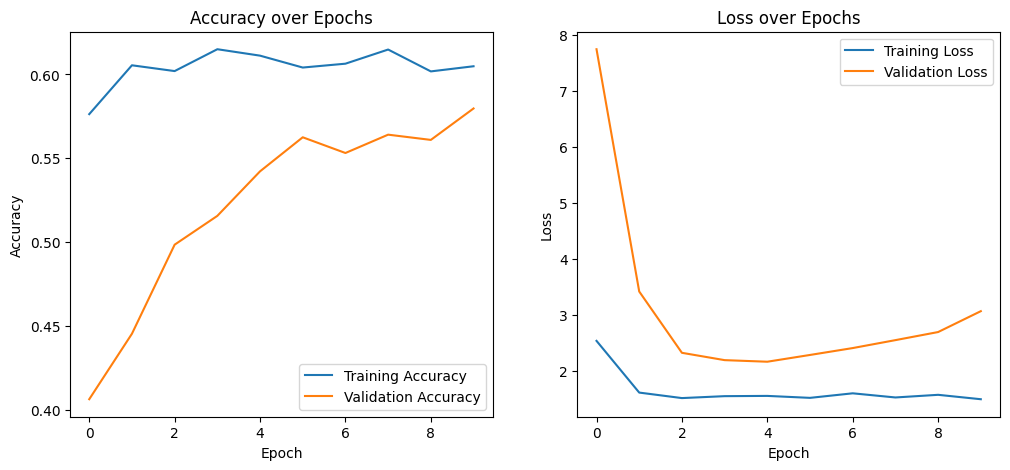

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Setting up the learning rate schedule
initial_learning_rate = 1e-3
final_learning_rate = 1e-5
decay_steps = 10
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate=(final_learning_rate / initial_learning_rate) ** (1 / decay_steps),
    staircase=True)

# Configuring the optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Compiling the model
model_keras.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(),
    metrics=['accuracy'])

# Setting up callbacks for saving the model and early stopping
checkpoint_cb = ModelCheckpoint(
    'akidanet_derma_best.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(
    patience=5, restore_best_weights=True)

# GB: To change nb of epochs 
# (on CPU, 1 epoch lasts 22 min, so 10 is 4 hours long)
EPOCHS = 15 # Initial value: 10

# Training the model
history = model_keras.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=test_gen,
    callbacks=[checkpoint_cb, early_stopping_cb])

# Optionally, plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2024-09-30 02:57:31.319968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


53/53 [==============================] - 32s 593ms/step


2024-09-30 02:58:03.208715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 2s 218ms/step


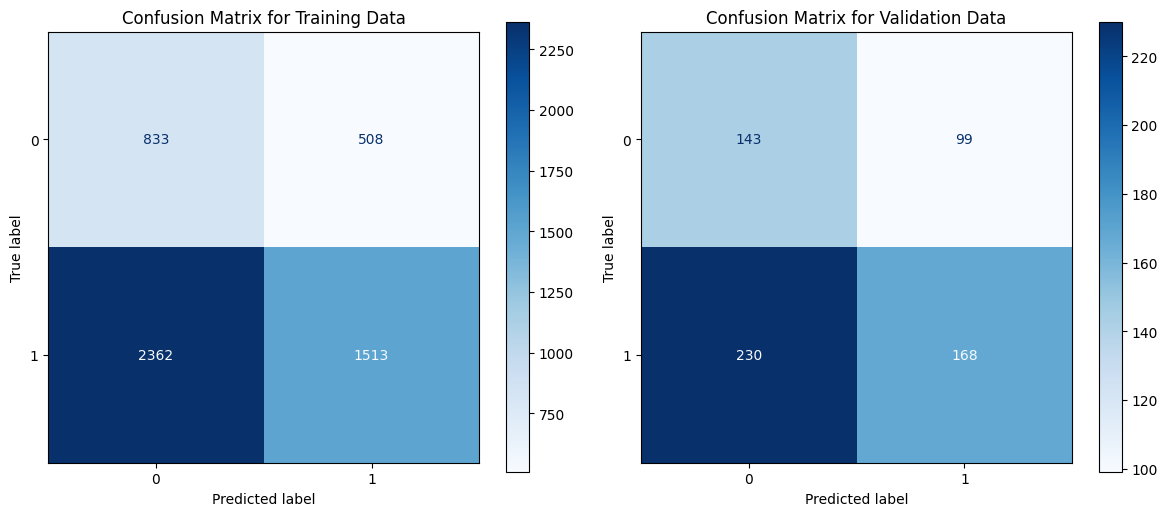

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtain predictions for the training and validation datasets
train_predictions = np.argmax(model_keras.predict(train_gen), axis=-1)
val_predictions = np.argmax(model_keras.predict(test_gen), axis=-1)

# Get true labels from the generators
train_labels = train_gen.classes
val_labels = test_gen.classes

# Compute confusion matrices
train_cm = confusion_matrix(train_labels, train_predictions)
val_cm = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix for training data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for Training Data')

# Plot confusion matrix for validation data
plt.subplot(1, 2, 2)
ConfusionMatrixDisplay(confusion_matrix=val_cm).plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for Validation Data')

plt.tight_layout()
plt.show()

In [14]:
# Function to convert generator to tf.data.Dataset
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Create a Dataset from the generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

train_dataset = train_dataset.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)

# Define batch size and batch the dataset
BATCH_SIZE = 16
train_batches = train_dataset.unbatch().batch(BATCH_SIZE)

## Quantize Model

In [15]:
from quantizeml.models import quantize, QuantizationParams, dump_config

# Prepare a quantization scheme: first layer weights to 8-bit, other weights and activation to 4-bit

# GB: Parameter per_tensor_activation = False, really? fot v1 models, you need to set this parameter to True, by default, it's False-> quantizeml.models.quantize(..., per_tensor_activations=False)
#qparams = QuantizationParams(input_weight_bits=8, weight_bits=4, activation_bits=4)
qparams = QuantizationParams(input_weight_bits=8, per_tensor_activations=True, weight_bits=4, activation_bits=4)

# Quantize the model, using the 1024 calibration samples from the train set and calibrate over 2
# epochs with a batch_size of 100.
model_quantized = quantize(model_keras, qparams=qparams, 
                           samples=train_batches, epochs=2, batch_size=BATCH_SIZE, num_samples=1024)


2024-09-30 02:58:12.446857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


64/64 [==============================] - 7s 95ms/step


In [16]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

test_dataset = test_dataset.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)

# Define batch size and batch the dataset
BATCH_SIZE = 32
test_batches = test_dataset.unbatch().batch(BATCH_SIZE)

In [17]:
import numpy as np

def generator_to_numpy(generator):
    images_list = []
    labels_list = []

    # Iterate through the generator
    for _ in range(len(generator)):
        images, labels = generator.next()
        images_list.append(images)
        labels_list.append(labels)

    # Concatenate lists into numpy arrays
    x_test = np.concatenate(images_list, axis=0)
    labels_test = np.concatenate(labels_list, axis=0)

    return x_test, labels_test

# Example usage with test_gen
x_test, labels_test = generator_to_numpy(test_gen)

# Ensure the shapes are correct
print(x_test.shape)  # Should be (num_samples, 224, 224, 3)
print(labels_test.shape)  # Should be (num_samples,)


(640, 224, 224, 3)
(640,)


2024-09-30 02:58:30.974352: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: akidanet_derma/conv_0/aligned_weight_quantizer/assert_less/Assert/AssertGuard/branch_executed/_25


7/7 [==============================] - 3s 46ms/step
Keras inference on 640 images took 3.15 s.

Keras accuracy: 349/640.


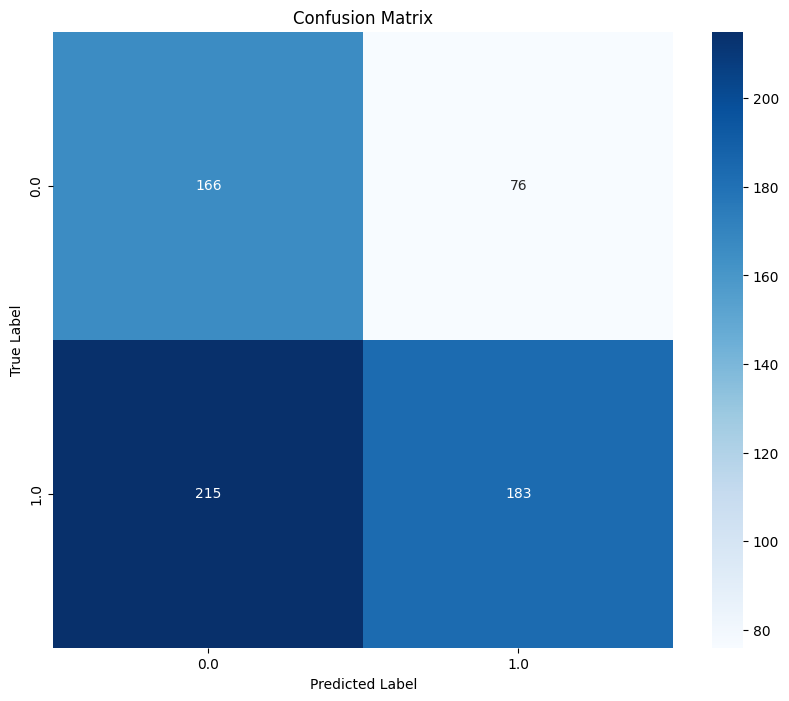

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from timeit import default_timer as timer

# Compile the model with the specified metric
model_quantized.compile(metrics=['accuracy'])

# Get the number of images in the test dataset
num_images = len(x_test)

# Measure the time taken for Keras inference
start = timer()
potentials_keras = model_quantized.predict(x_test, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

# Get the predicted labels from the model output
preds_keras = np.squeeze(np.argmax(potentials_keras, 1))

# Calculate the accuracy
accuracy_keras = np.sum(np.equal(preds_keras, labels_test)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

# Generate the confusion matrix
cm = confusion_matrix(labels_test, preds_keras)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels_test), yticklabels=np.unique(labels_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# GB: Adding Keras Floating-point accuracy to compare with previous one

model_keras.compile(metrics=['accuracy'])

num_images = len(x_test)

start = timer()
potentials_keras = model_keras.predict(x_test, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

preds_keras = np.squeeze(np.argmax(potentials_keras, 1))
accuracy_keras = np.sum(np.equal(preds_keras, labels_test)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

7/7 [==============================] - 0s 11ms/step
Keras inference on 640 images took 0.38 s.

Keras accuracy: 347/640.


In [20]:
# GB: Name changed
model_quantized.save('model_quantized_v1.h5')

In [21]:
import numpy as np
from cnn2snn import convert

model_akida = convert(model_quantized)


In [22]:
model_akida.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [1, 1, 2]     1          16    
________________________________________________

____________________________________________________________
Layer (type)              Output shape    Kernel shape    

============= SW/conv_0-predictions (Software) =============

conv_0 (InputConv.)       [112, 112, 16]  (3, 3, 3, 16)   
____________________________________________________________
conv_1 (Conv.)            [112, 112, 32]  (3, 3, 16, 32)  
____________________________________________________________
conv_2 (Conv.)            [56, 56, 64]    (3, 3, 32, 64)  
____________________________________________________________
conv_3 (Conv.)            [56, 56, 64]    (3, 3, 64, 64)  
____________________________________________________________
separable_4 (Sep.Conv.)   [28, 28, 128]   (3, 3, 64, 1)   
____________________________________

In [23]:
# GB: I do not understand this block, I guess you skip it in normal flow, or you start here ...

# from tensorflow.keras.models import load_model
# from akida_models import load_model

# model_path = 'model_akida_v1.fbz'
# model_akida = load_model(model_path)

# model_akida.summary()

In [24]:
# GB: Change model name to v1
model_akida.save('model_akida_v1.fbz')

In [25]:
# GB: Get device (again)
# myDevice = ak.devices()[1]
# print('Device: ', myDevice.desc)
# model_akida.map(myDevice)
# model_akida.summary()

In [26]:
# Check Model performance
start = timer()
accuracy_akida = model_akida.evaluate(x_test, labels_test)
end = timer()
print(f'Inference on {num_images} images took {end-start:.2f} s.\n')
print(f"Accuracy: {accuracy_akida*num_images:.0f}/{num_images}.")

Inference on 640 images took 2.46 s.

Accuracy: 352/640.


In [27]:
import numpy as np


# Get the class indices for each sample
class_indices = test_gen.classes

# Get the mapping from class names to indices
class_indices_mapping = test_gen.class_indices

# Create a reverse mapping from indices to class names
index_to_class = {v: k for k, v in class_indices_mapping.items()}

# Count the number of samples for each class
class_counts = np.bincount(class_indices)

# Print the number of samples for each class
print("Number of samples:", test_gen.samples)
print("Number of samples per class in the test generator:")
for class_index, count in enumerate(class_counts):
    class_name = index_to_class[class_index]
    print(f"{class_name}: {count}")


Number of samples: 640
Number of samples per class in the test generator:
NORMAL: 242
PNEUMONIA: 398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0, 0, 0, 0, 0]
[1. 1. 1. 1. 1. 0.]
['NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', '']
Akida outputs: [ 0.06083289 -1.2738441 ]
True label: NORMAL
Predicted label: NORMAL


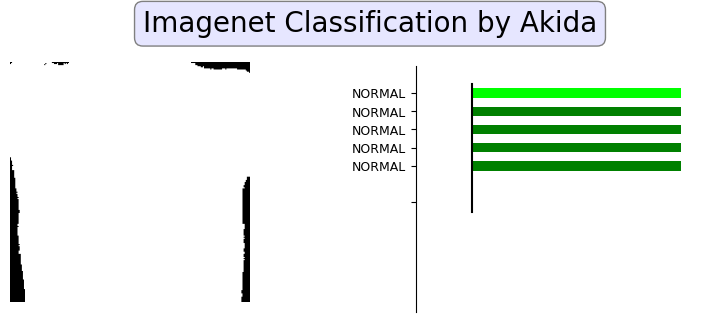

In [41]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from akida_models.imagenet import preprocessing

class_names = ['NORMAL', 'PNEUMONIA']

IMAGE_SIZE = 224
NUM_CHANNELS = 3

# Functions used to display the top5 results
def get_top5(potentials, true_label):
    """
    Returns the top 5 classes from the output potentials
    """
    tmp_pots = potentials.copy()
    top5 = []
    min_val = np.min(tmp_pots)
    for ii in range(5):
        best = np.argmax(tmp_pots)
        top5.append(best)
        tmp_pots[best] = min_val

    vals = np.zeros((6,))
    vals[:5] = potentials[top5]

    if true_label not in top5:
        vals[5] = potentials[true_label]
    else:
        vals[5] = 0

    vals /= np.max(vals)

    class_name = []
    for ii in range(5):
        class_name.append(class_names[top5[ii]])
    if true_label in top5:
        class_name.append('')
    else:
        class_name.append(
            class_names[true_label])

    return top5, vals, class_name


def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])


def prepare_plots():
    fig = plt.figure(figsize=(8, 4))
    # Image subplot
    ax0 = plt.subplot(1, 3, 1)
    imgobj = ax0.imshow(np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), dtype=np.uint8))
    ax0.set_axis_off()
    # Top 5 results subplot
    ax1 = plt.subplot(1, 2, 2)
    bar_positions = (0, 1, 2, 3, 4, 6)
    rects = ax1.barh(bar_positions, np.zeros((6,)), align='center', height=0.5)
    plt.xlim(-0.2, 1.01)
    ax1.set(xlim=(-0.2, 1.15), ylim=(-1.5, 12))
    ax1.set_yticks(bar_positions)
    ax1.invert_yaxis()
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks([])
    adjust_spines(ax1, 'left')
    ax1.add_line(lines.Line2D((0, 0), (-0.5, 6.5), color=(0.0, 0.0, 0.0)))
    # Adjust Plot Positions
    ax0.set_position([0.05, 0.055, 0.3, 0.9])
    l1, b1, w1, h1 = ax1.get_position().bounds
    ax1.set_position([l1 * 1.05, b1 + 0.09 * h1, w1, 0.8 * h1])
    # Add title box
    plt.figtext(0.5,
                0.9,
                "Imagenet Classification by Akida",
                size=20,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round",
                          ec=(0.5, 0.5, 0.5),
                          fc=(0.9, 0.9, 1.0)))

    return fig, imgobj, ax1, rects


def update_bars_chart(rects, vals, true_label):
    counter = 0
    for rect, h in zip(rects, yvals):
        rect.set_width(h)
        if counter < 5:
            if top5[counter] == true_label:
                if counter == 0:
                    rect.set_facecolor((0.0, 1.0, 0.0))
                else:
                    rect.set_facecolor((0.0, 0.5, 0.0))
            else:
                rect.set_facecolor('gray')
        elif counter == 5:
            rect.set_facecolor('red')
        counter += 1


# Prepare plots
fig, imgobj, ax1, rects = prepare_plots()

# Get a random image
img = np.random.randint(num_images)

# Predict image class
outputs_akida = model_akida.predict(np.expand_dims(x_test[img].astype(np.uint8), axis=0)).squeeze()

# Get top 5 prediction labels and associated names
true_label = labels_test[img]

# GB: Added, because of last layer activation function
true_label = int(true_label)

top5, yvals, class_name = get_top5(outputs_akida, true_label)
print(top5)
print(yvals)
print(class_name)

print("Akida outputs:", outputs_akida)
print("True label:", class_names[int(true_label)])
print("Predicted label:", class_names[np.argmax(outputs_akida)])

# Draw Plots
imgobj.set_data(x_test[img])
ax1.set_yticklabels(class_name, rotation='horizontal', size=9)
update_bars_chart(rects, yvals, true_label)
fig.canvas.draw()
plt.show()

In [42]:
tf.keras.backend.clear_session()